In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import datetime as dt

In [20]:
customers_df= pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv')
geolocation_df= pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv')
items_df= pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')
payments_df= pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')
reviews_df= pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv')
orders_df= pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv')
products_df= pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv')
sellers_df= pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv')
category_translation_df= pd.read_csv('/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv')

In [21]:
datasets = [customers_df, geolocation_df, items_df, payments_df, reviews_df, orders_df, products_df, sellers_df, category_translation_df]
titles = ["customers", "geolocation", "items", "payments", "reviews", "orders", "products", "sellers", "category_translation"]

data_summary = pd.DataFrame({},)
data_summary['datasets']= titles
data_summary['columns'] = [', '.join([col for col, null in data.isnull().sum().items() ]) for data in datasets]
data_summary['total_rows']= [data.shape[0] for data in datasets]
data_summary['total_cols']= [data.shape[1] for data in datasets]
data_summary['total_duplicate']= [len(data[data.duplicated()]) for data in datasets]
data_summary['total_null']= [data.isnull().sum().sum() for data in datasets]
data_summary['null_cols'] = [', '.join([col for col, null in data.isnull().sum().items() if null > 0]) for data in datasets]
data_summary.style.background_gradient(cmap='YlGnBu')

,datasets,columns,total_rows,total_cols,total_duplicate,total_null,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441,5,0,0,
1,geolocation,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",1000163,5,261831,0,
2,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650,7,0,0,
3,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886,5,0,0,
4,reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",99224,7,0,145903,"review_comment_title, review_comment_message"
5,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",99441,8,0,4908,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
6,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32951,9,0,2448,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,sellers,"seller_id, seller_zip_code_prefix, seller_city, seller_state",3095,4,0,0,
8,category_translation,"product_category_name, product_category_name_english",71,2,0,0,


In [22]:
for i in datasets:
    i.dropna(inplace=True)

In [23]:
for i in datasets:
    i.drop(i[i.duplicated()].index, axis=0, inplace=True)

In [24]:
data_summary = pd.DataFrame({},)
data_summary['datasets']= titles
data_summary['columns'] = [', '.join([col for col, null in data.isnull().sum().items() ]) for data in datasets]
data_summary['total_rows']= [data.shape[0] for data in datasets]
data_summary['total_cols']= [data.shape[1] for data in datasets]
data_summary['total_duplicate']= [len(data[data.duplicated()]) for data in datasets]
data_summary['total_null']= [data.isnull().sum().sum() for data in datasets]
data_summary['null_cols'] = [', '.join([col for col, null in data.isnull().sum().items() if null > 0]) for data in datasets]
data_summary.style.background_gradient(cmap='YlGnBu')


,datasets,columns,total_rows,total_cols,total_duplicate,total_null,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441,5,0,0,
1,geolocation,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",738332,5,0,0,
2,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650,7,0,0,
3,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886,5,0,0,
4,reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",9839,7,0,0,
5,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",96461,8,0,0,
6,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32340,9,0,0,
7,sellers,"seller_id, seller_zip_code_prefix, seller_city, seller_state",3095,4,0,0,
8,category_translation,"product_category_name, product_category_name_english",71,2,0,0,


In [25]:
merged_df= pd.merge(customers_df, orders_df, on="customer_id")
merged_df= merged_df.merge(items_df, on="order_id")
merged_df= merged_df.merge(products_df, on="product_id")
merged_df= merged_df.merge(payments_df, on="order_id")
merged_df= merged_df.merge(sellers_df, on='seller_id')
merged_df= merged_df.merge(category_translation_df, on='product_category_name')
merged_df.shape

(113367, 34)

In [26]:
time_columns= ['order_purchase_timestamp', 'order_approved_at','order_delivered_carrier_date','order_delivered_customer_date',
               'order_estimated_delivery_date', 'shipping_limit_date']

merged_df[time_columns]=merged_df[time_columns].apply(pd.to_datetime)

In [27]:
present_day = merged_df['order_purchase_timestamp'].max() + dt.timedelta(days=2)
print("Latest date in dataset: ", merged_df['order_purchase_timestamp'].max())

recency_df= pd.DataFrame(merged_df.groupby(by='customer_unique_id', as_index=False)['order_purchase_timestamp'].max())
recency_df['Recency']= recency_df['order_purchase_timestamp'].apply(lambda x: (present_day - x).days)

Latest date in dataset:  2018-08-29 15:00:37


In [28]:
tenure_df= pd.DataFrame(merged_df.groupby(by='customer_unique_id', as_index=False)['order_purchase_timestamp'].min())
tenure_df['Tenure']= tenure_df['order_purchase_timestamp'].apply(lambda x: (present_day - x).days)

In [29]:
frequency_df = pd.DataFrame(merged_df.groupby(["customer_unique_id"]).agg({"order_id":"nunique"}).reset_index())
frequency_df.rename(columns={"order_id":"Frequency"}, inplace=True)

In [30]:
monetary_df = merged_df.groupby('customer_unique_id', as_index=False)['payment_value'].sum()
monetary_df.columns = ['customer_unique_id', 'Monetary']

In [31]:
recency_df.head()

,customer_unique_id,order_purchase_timestamp,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,113
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,116
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,538
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,322
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,289


In [32]:
RF_df = recency_df.merge(frequency_df, on='customer_unique_id')
RFM_df = RF_df.merge(monetary_df, on='customer_unique_id').drop(columns='order_purchase_timestamp')
RFM_df = RFM_df.merge(tenure_df, on='customer_unique_id').drop(columns='order_purchase_timestamp')
RFM_df.head()

,customer_unique_id,Recency,Frequency,Monetary,Tenure
0,0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,113
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,116
2,0000f46a3911fa3c0805444483337064,538,1,86.22,538
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,322
4,0004aac84e0df4da2b147fca70cf8255,289,1,196.89,289


In [33]:
RFM_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,92062.0,238.241120,152.570422,2.00,115.00,219.00,347.0000,696.00
Frequency,92062.0,1.033097,0.206880,1.00,1.00,1.00,1.0000,14.00
Monetary,92062.0,212.077653,643.667355,9.59,63.83,112.81,202.1375,109312.64
Tenure,92062.0,240.859432,153.081916,2.00,116.00,222.00,351.0000,697.00


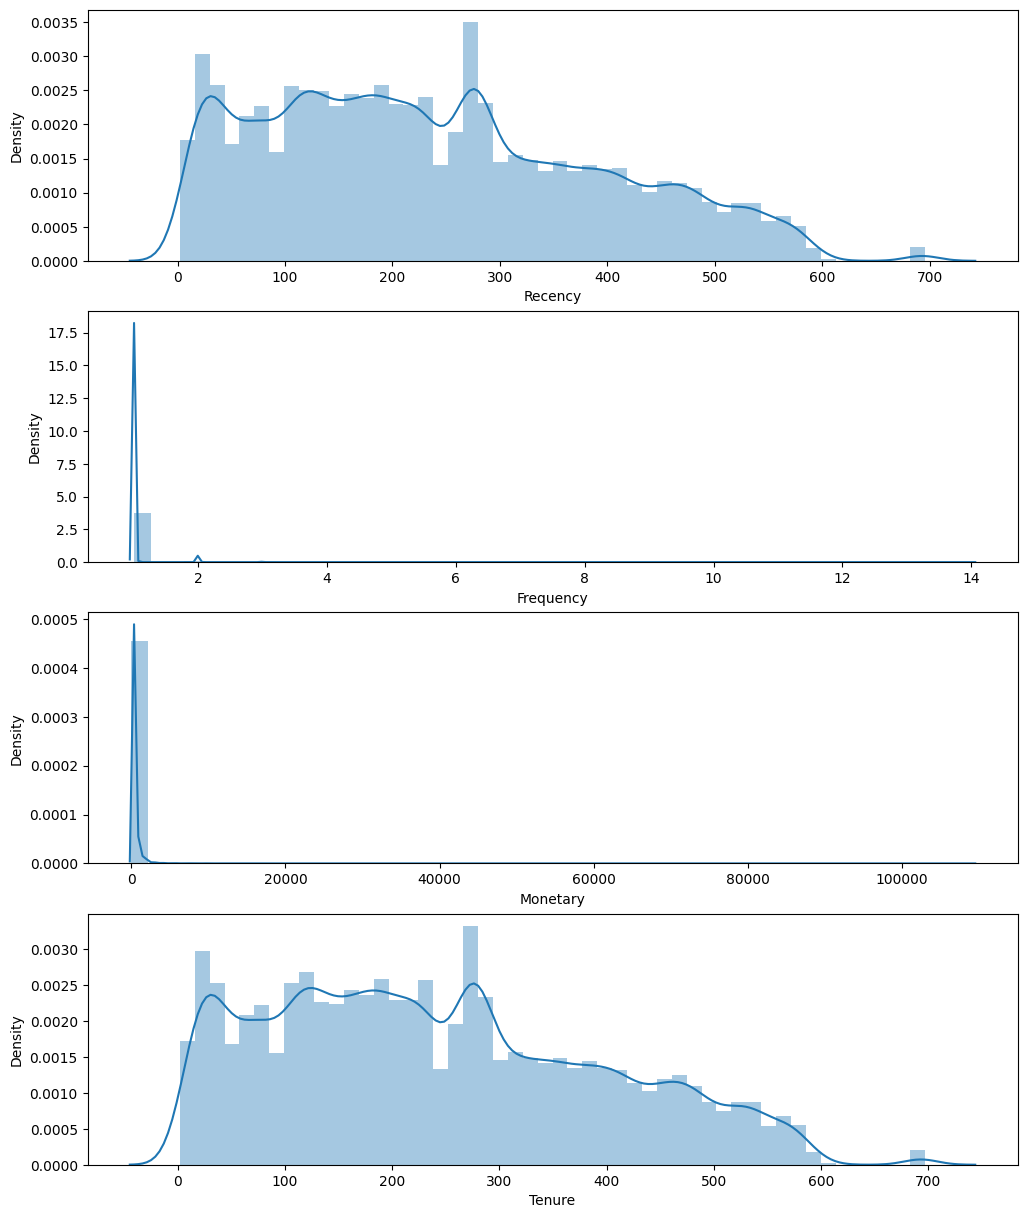

In [34]:
plt.figure(figsize=(12, 15))
plt.subplot(4, 1, 1); sns.distplot(RFM_df['Recency'])
plt.subplot(4, 1, 2); sns.distplot(RFM_df['Frequency'])
plt.subplot(4, 1, 3); sns.distplot(RFM_df['Monetary'])
plt.subplot(4, 1, 4); sns.distplot(RFM_df['Tenure'])
plt.show()

In [35]:
RFM_df2= RFM_df.copy()
RFM_df2= RFM_df2.set_index('customer_unique_id')

In [36]:
RFM_df2["recency_score"]  = pd.qcut(RFM_df2['Recency'], 5, labels=[5, 4, 3, 2, 1])
RFM_df2["frequency_score"]= pd.qcut(RFM_df2['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
RFM_df2["monetary_score"] = pd.qcut(RFM_df2['Monetary'], 5, labels=[1, 2, 3, 4, 5])

In [37]:
RFM_df2['RFM_SCORE'] = RFM_df2.recency_score.astype(str)+ RFM_df2.frequency_score.astype(str) + RFM_df2.monetary_score.astype(str)
RFM_df2.head()

,Recency,Frequency,Monetary,Tenure,recency_score,frequency_score,monetary_score,RFM_SCORE
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,113,4,1,4,414
0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,116,4,1,1,411
0000f46a3911fa3c0805444483337064,538,1,86.22,538,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,322,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,289,1,196.89,289,2,1,4,214


In [38]:
seg_map= {
    r'111|112|121|131|141|151': 'Lost customers',
    r'332|322|233|232|223|222|132|123|122|212|211': 'Hibernating customers', 
    r'155|154|144|214|215|115|114|113': 'Cannot Lose Them',
    r'255|254|245|244|253|252|243|242|235|234|225|224|153|152|145|143|142|135|134|133|125|124': 'At Risk',
    r'331|321|312|221|213|231|241|251': 'About To Sleep',
    r'535|534|443|434|343|334|325|324': 'Need Attention',
    r'525|524|523|522|521|515|514|513|425|424|413|414|415|315|314|313': 'Promising',
    r'512|511|422|421|412|411|311': 'New Customers',
    r'553|551|552|541|542|533|532|531|452|451|442|441|431|453|433|432|423|353|352|351|342|341|333|323': 'Potential Loyalist',
    r'543|444|435|355|354|345|344|335': 'Loyal',
    r'555|554|544|545|454|455|445': 'Champions'
}

In [39]:
#RFM_df2['Segment'] = RFM_df2['recency_score'].astype(str) + RFM_df2['frequency_score'].astype(str) + RFM_df2['monetary_score'].astype(str)
RFM_df2['Segment'] = RFM_df2['RFM_SCORE'].replace(seg_map, regex=True)
RFM_df2.head()

,Recency,Frequency,Monetary,Tenure,recency_score,frequency_score,monetary_score,RFM_SCORE,Segment
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,113,4,1,4,414,Promising
0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,116,4,1,1,411,New Customers
0000f46a3911fa3c0805444483337064,538,1,86.22,538,1,1,2,112,Lost customers
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,322,2,1,1,211,Hibernating customers
0004aac84e0df4da2b147fca70cf8255,289,1,196.89,289,2,1,4,214,Cannot Lose Them


In [41]:
RFMStats = RFM_df2[["Segment", "Recency", "Frequency", "Monetary"]].groupby("Segment").agg(['mean','median', 'min', 'max', 'count'])
RFMStats

Recency                         Frequency         \
                             mean median  min  max  count      mean median   
Segment                                                                      
About To Sleep         277.295159  279.0  178  382   5763  1.000694    1.0   
At Risk                386.307774  367.0  270  696  15911  1.043555    1.0   
Cannot Lose Them       436.652977  438.0  270  696   5844  1.056810    1.0   
Champions               85.297225   81.0    2  177   5622  1.199039    1.0   
Hibernating customers  342.760420  326.0  178  695   8277  1.000000    1.0   
Lost customers         475.489774  469.0  383  696   4596  1.001958    1.0   
Loyal                  178.075491  192.0    2  269   6014  1.092451    1.0   
Need Attention         156.420960  178.0    2  269   5668  1.000000    1.0   
New Customers          124.386206  127.0    2  269   5176  1.000000    1.0   
Potential Loyalist     131.136241  130.0    2  269  17359  1.019241    1.0   
Promising              106.227350   92.0    2  269  11832  1.000000    1.0   

                                        Monetary                              \
                      min max  count        mean   median     min        max   
Segment                                                                        
About To Sleep          1   2   5763   52.815379   45.000   10.07     139.80   
At Risk                 1   6  15911  296.585130  162.850   56.05   45256.00   
Cannot Lose Them        1   4   5844  365.213537  204.340   89.70  109312.64   
Champions               1  14   5622  477.082716  268.505  139.88   30186.00   
Hibernating customers   1   1   8277   80.081653   75.620   11.63     139.86   
Lost customers          1   3   4596   45.284967   43.620   12.28      89.29   
Loyal                   1   9   6014  394.027797  238.350   89.73   44048.00   
Need Attention          1   1   5668  271.751277  174.300   89.74   29099.52   
New Customers           1   1   5176   53.281372   51.320    9.59      89.67   
Potential Loyalist      1   3  17359   75.282727   70.910   10.89     139.86   
Promising               1   1  11832  280.673829  165.040   14.06   19174.38   

                              
                       count  
Segment                       
About To Sleep          5763  
At Risk                15911  
Cannot Lose Them        5844  
Champions               5622  
Hibernating customers   8277  
Lost customers          4596  
Loyal                   6014  
Need Attention          5668  
New Customers           5176  
Potential Loyalist     17359  
Promising              11832

In [42]:
RFMStats['Ratio']= (100*RFMStats['Monetary']["count"]/RFMStats['Monetary']["count"].sum()).round(2)

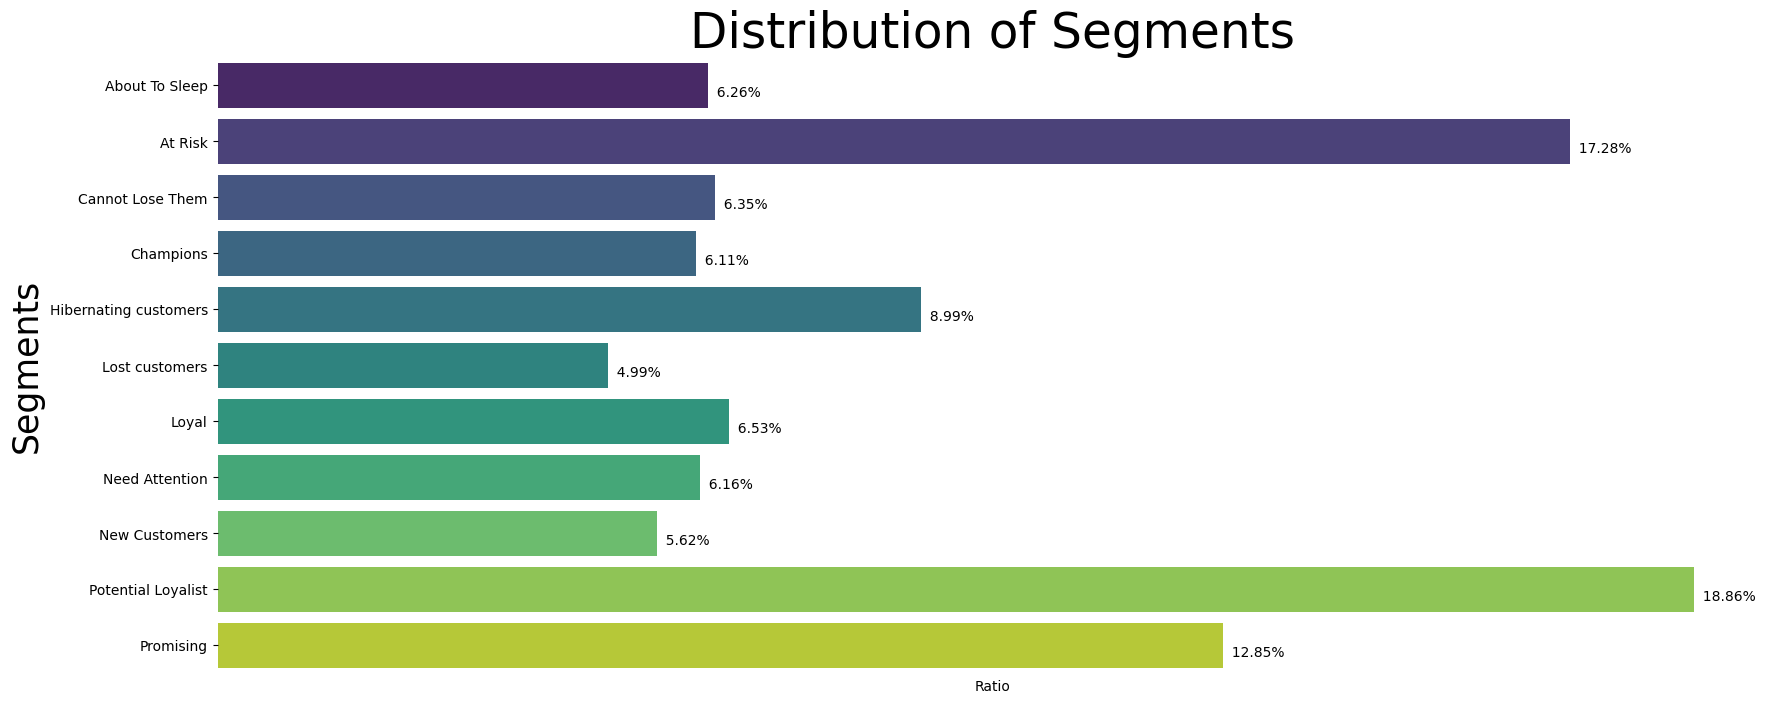

In [43]:
plt.figure(figsize=(20,8))
#plt.rc('font', size=20)
per= sns.barplot(x=RFMStats['Ratio'], y=RFMStats.index, data=RFMStats, palette="viridis")
sns.despine(bottom = True, left = True)
for i, v in enumerate(RFMStats['Ratio']):
    per.text(v, i+.20,"  {:.2f}".format(v)+"%", color='black', ha="left")
per.set_ylabel('Segments', fontsize=25)
per.set(xticks=[])
plt.title('Distribution of Segments', fontsize=35)
plt.show()

In [44]:
import squarify

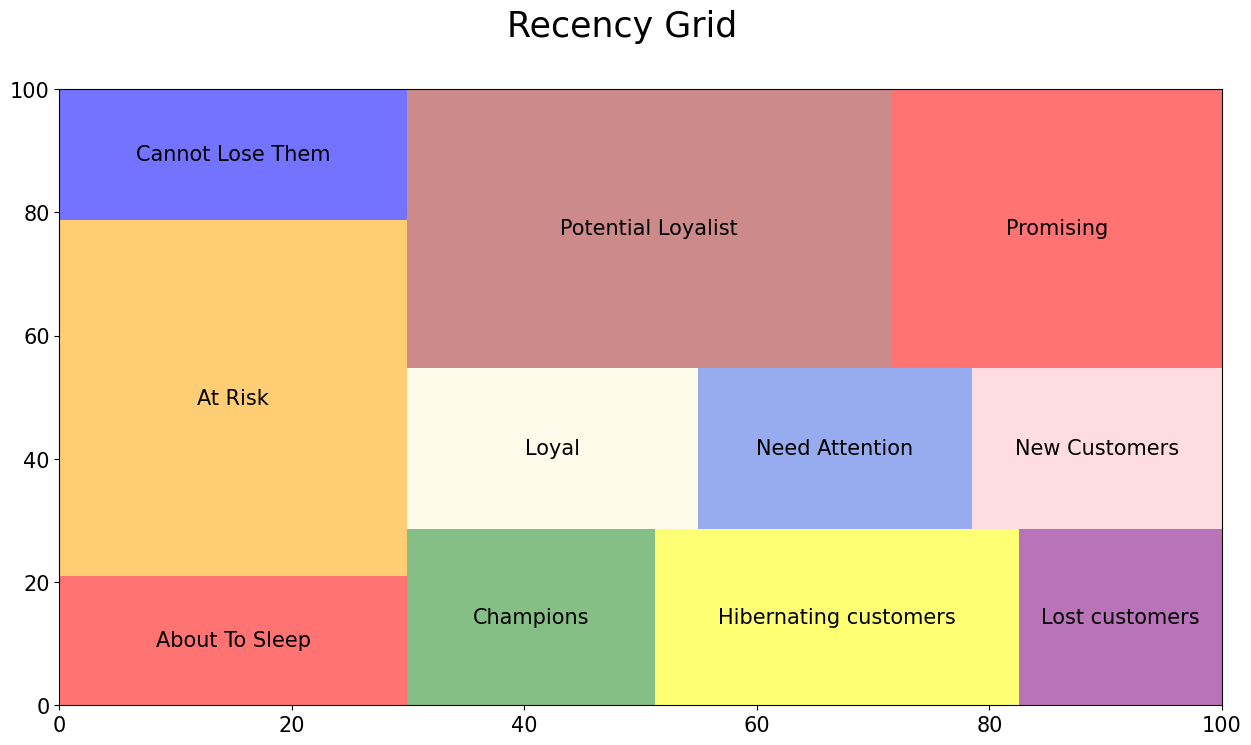

In [45]:
# Treemap by recency/frequency
plt.figure(figsize=(15,8))
plt.rc('font', size=15)
squarify.plot(sizes=RFMStats["Recency"]["count"], label=RFMStats.index, 
              color=["red","orange","blue", "forestgreen", "yellow", "purple", "cornsilk","royalblue", "pink", "brown"], alpha=.55)
plt.suptitle("Recency Grid", fontsize=25);

In [46]:
!pip install Lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 10.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.2 MB/s eta 0:00:00


In [47]:
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from sklearn.metrics import mean_squared_error

In [48]:
diff_time = merged_df['order_purchase_timestamp'].max() - merged_df['order_purchase_timestamp'].min() 
diff_time

Timedelta('695 days 05:15:47')

In [49]:
# Getting the endingabs date of the calibration period. 
end_date_cal = merged_df['order_purchase_timestamp'].min() + dt.timedelta(days=450)
end_date_obs = end_date_cal + (diff_time - dt.timedelta(days=450))

In [50]:
df_rfmt = summary_data_from_transaction_data(transactions = merged_df, 
                                         customer_id_col = 'customer_unique_id', 
                                         datetime_col = 'order_purchase_timestamp', 
                                         monetary_value_col = 'payment_value')
df_rfmt.head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,111.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,114.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,537.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,321.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,288.0,0.0


In [51]:
df_rfmt_cal = calibration_and_holdout_data(transactions=merged_df, 
                                          customer_id_col="customer_unique_id",
                                          datetime_col = "order_purchase_timestamp", 
                                          calibration_period_end=end_date_cal,
                                          observation_period_end= end_date_obs)
df_rfmt_cal

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
customer_unique_id,,,,,
0000f46a3911fa3c0805444483337064,0.0,0.0,292.0,0.0,245.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,76.0,0.0,245.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,43.0,0.0,245.0
0005e1862207bf6ccc02e4228effd9a0,0.0,0.0,298.0,0.0,245.0
0006fdc98a402fceb4eb0ee528f6a8d4,0.0,0.0,162.0,0.0,245.0
...,...,...,...,...,...
fffb09418989a0dbff854a28163e47c6,0.0,0.0,10.0,0.0,245.0
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,202.0,0.0,245.0
fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,17.0,0.0,245.0


In [52]:
l2_coefs = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
l2_list = []
rmse_list = []
for coef in l2_coefs :
    # Fitting the model using the calibration dataset.
    model = BetaGeoFitter(penalizer_coef=coef)
    model.fit(df_rfmt_cal['frequency_cal'], 
        df_rfmt_cal['recency_cal'], 
        df_rfmt_cal['T_cal'])
    # Predicting the frequency for the holdout period for all customers. 
    pred_freq = pd.DataFrame(model.predict(df_rfmt_cal['duration_holdout'], 
                                 df_rfmt_cal['frequency_cal'], df_rfmt_cal['recency_cal'], df_rfmt_cal['T_cal']), columns=['pred_frequency']).reset_index()
    # Merging the two dataframes and dropping NaN values. 
    new_df = df_rfmt_cal.reset_index().merge(pred_freq, on='customer_unique_id').dropna()

    # Computing the rmse score 
    rmse_score = np.sqrt(mean_squared_error(new_df['frequency_holdout'],new_df['pred_frequency']))
    l2_list.append(coef)
    rmse_list.append(rmse_score)

# Getting the results 
resl = pd.DataFrame(np.array(rmse_list), columns=['rmse_score'])\
             .merge(pd.DataFrame(np.array(l2_list), columns=['L2 coefs']), right_index=True, left_index=True)
resl

,rmse_score,L2 coefs
0,0.187183,0.3
1,0.189594,0.4
2,0.191439,0.5
3,0.192924,0.6
4,0.194160,0.7
5,0.195215,0.8
6,0.196132,0.9
7,0.196941,1.0


In [53]:
# Fitting the model using the calibration dataset.
model = BetaGeoFitter(penalizer_coef=0.30)
model.fit(df_rfmt_cal['frequency_cal'], 
        df_rfmt_cal['recency_cal'], 
        df_rfmt_cal['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 41112 subjects, a: 0.01, alpha: 20.13, b: 0.00, r: 0.01>

In [54]:
# Predicting the number of purchases in the next 180 days for all customers.
df_rfmt['predicted_purchases'] = model.conditional_expected_number_of_purchases_up_to_time(180, 
                                                                                      df_rfmt['frequency'], 
                                                                                      df_rfmt['recency'], 
                                                                                      df_rfmt['T'])
df_rfmt.dropna(inplace=True)
# Getting rid of negative values.
df_rfmt = df_rfmt[df_rfmt['monetary_value']>0]
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases
customer_unique_id,,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,398.0,103.280,0.027480
00a39521eb40f7012db50455bf083460,1.0,11.0,98.0,26.780,0.057116
011575986092c30523ecb71ff10cb473,1.0,60.0,193.0,80.320,0.044691
011b4adcd54683b480c4d841250a987f,1.0,177.0,372.0,299.760,0.032044
012452d40dafae4df401bced74cdb490,1.0,330.0,437.0,340.070,0.040567
...,...,...,...,...,...
fe81bb32c243a86b2f86fbf053fe6140,4.0,242.0,311.0,381.745,2.162221
fed519569d16e690df6f89cb99d4e682,1.0,88.0,252.0,110.260,0.036926
ff03923ad1eb9e32304deb7f9b2a45c9,1.0,33.0,128.0,123.530,0.061388


In [55]:
# Fitting the GammaGamma model 

gg_model = GammaGammaFitter()
gg_model.fit(df_rfmt['frequency'], df_rfmt['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 1974 subjects, p: 11.50, q: 1.72, v: 14.22>

In [56]:
df_rfmt['pred_monetary'] = gg_model.conditional_expected_average_profit(
        df_rfmt['frequency'],
        df_rfmt['monetary_value'])
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary
customer_unique_id,,,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,398.0,103.280,0.027480,110.538904
00a39521eb40f7012db50455bf083460,1.0,11.0,98.0,26.780,0.057116,38.572042
011575986092c30523ecb71ff10cb473,1.0,60.0,193.0,80.320,0.044691,88.939438
011b4adcd54683b480c4d841250a987f,1.0,177.0,372.0,299.760,0.032044,295.376145
012452d40dafae4df401bced74cdb490,1.0,330.0,437.0,340.070,0.040567,333.297507
...,...,...,...,...,...,...
fe81bb32c243a86b2f86fbf053fe6140,4.0,242.0,311.0,381.745,2.162221,379.327035
fed519569d16e690df6f89cb99d4e682,1.0,88.0,252.0,110.260,0.036926,117.105292
ff03923ad1eb9e32304deb7f9b2a45c9,1.0,33.0,128.0,123.530,0.061388,129.588955


In [57]:
# Predicting the CLV.
df_rfmt['CLV'] = gg_model.customer_lifetime_value(
    model,
    df_rfmt['frequency'],
    df_rfmt['recency'],
    df_rfmt['T'],
    df_rfmt['monetary_value'],
    time = 6,# In months 
    )
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV
customer_unique_id,,,,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,398.0,103.280,0.027480,110.538904,2.934086
00a39521eb40f7012db50455bf083460,1.0,11.0,98.0,26.780,0.057116,38.572042,2.128080
011575986092c30523ecb71ff10cb473,1.0,60.0,193.0,80.320,0.044691,88.939438,3.839403
011b4adcd54683b480c4d841250a987f,1.0,177.0,372.0,299.760,0.032044,295.376145,9.142732
012452d40dafae4df401bced74cdb490,1.0,330.0,437.0,340.070,0.040567,333.297507,13.060312
...,...,...,...,...,...,...,...
fe81bb32c243a86b2f86fbf053fe6140,4.0,242.0,311.0,381.745,2.162221,379.327035,792.244908
fed519569d16e690df6f89cb99d4e682,1.0,88.0,252.0,110.260,0.036926,117.105292,4.176931
ff03923ad1eb9e32304deb7f9b2a45c9,1.0,33.0,128.0,123.530,0.061388,129.588955,7.684420


In [58]:
#check if data is skewed
from scipy import stats #library
def check_skew(df, column):
    skew = stats.skew(df[column])
    skewtest = stats.skewtest(df[column])
#     plt.title('Distribution of ' + column)
#     sns.distplot(df[column])
#     plt.show()
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

In [59]:
for col in df_rfmt.columns:
    check_skew(df_rfmt, col)

frequency's: Skew: 10.818946613019369, : SkewtestResult(statistic=48.93137577521929, pvalue=0.0)
recency's: Skew: 1.2098738320181184, : SkewtestResult(statistic=17.64009520424301, pvalue=1.2125650364602188e-69)
T's: Skew: 0.0017794019490973373, : SkewtestResult(statistic=0.03239692414984523, pvalue=0.9741555153749359)
monetary_value's: Skew: 17.276346358700742, : SkewtestResult(statistic=55.91564888845654, pvalue=0.0)
predicted_purchases's: Skew: 5.499465675606559, : SkewtestResult(statistic=38.87645223121926, pvalue=0.0)
pred_monetary's: Skew: 17.21247246373088, : SkewtestResult(statistic=55.86033513284222, pvalue=0.0)
CLV's: Skew: 14.426952461778548, : SkewtestResult(statistic=53.224664889523375, pvalue=0.0)


In [60]:
RFM_log= df_rfmt.copy()
for i in RFM_log.drop('T', axis=1):
    RFM_log[i] = np.log10(RFM_log[i])
RFM_log.head()

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV
customer_unique_id,,,,,,,
004288347e5e88a27ded2bb23747066c,0.0,2.232996,398.0,2.014016,-1.560990,2.043515,0.467473
00a39521eb40f7012db50455bf083460,0.0,1.041393,98.0,1.427811,-1.243244,1.586273,0.327988
011575986092c30523ecb71ff10cb473,0.0,1.778151,193.0,1.904824,-1.349784,1.949094,0.584264
011b4adcd54683b480c4d841250a987f,0.0,2.247973,372.0,2.476774,-1.494247,2.470375,0.961076
012452d40dafae4df401bced74cdb490,0.0,2.518514,437.0,2.531568,-1.391825,2.522832,1.115954


In [61]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()

RFM_log_scaled= scaler.fit_transform(RFM_log)
RFM_log_scaled_df= pd.DataFrame(RFM_log_scaled)
RFM_log_scaled_df.columns = RFM_log.columns
RFM_log_scaled_df.head()

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV
0,-0.265332,0.720471,0.580774,-0.203436,-0.218664,-0.243268,-0.304867
1,-0.265332,-1.194001,-1.464860,-1.659905,0.306827,-1.506616,-0.497925
2,-0.265332,-0.010299,-0.817076,-0.474732,0.130631,-0.504150,-0.143219
3,-0.265332,0.744534,0.403486,0.946317,-0.108284,0.936135,0.378319
4,-0.265332,1.179194,0.846707,1.082458,0.061102,1.081071,0.592681


In [62]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

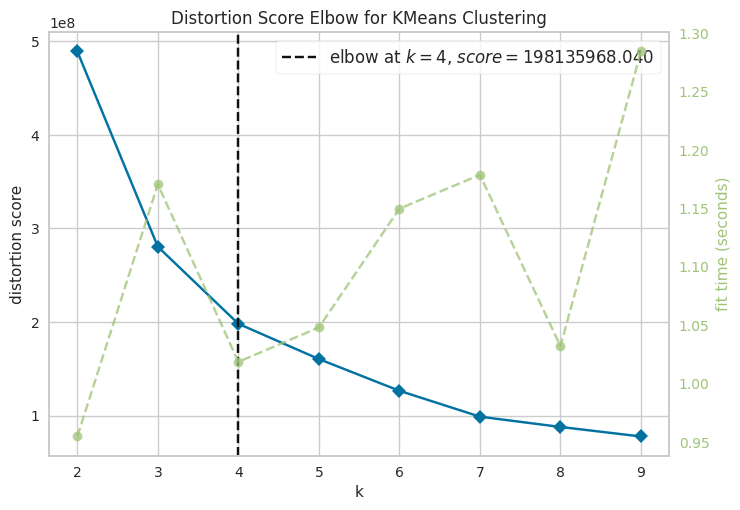

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [63]:
from yellowbrick.cluster import KElbowVisualizer


# Instantiate the clustering model and visualizer
km_model = KMeans()
visualizer = KElbowVisualizer(km_model, k=(2,10))

visualizer.fit(df_rfmt)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [64]:
km_model = KMeans(n_clusters=4)
km_model.fit(df_rfmt)
# Creating a new column called cluster whose values are the corresponding cluster for each point.
df_rfmt['cluster'] = km_model.labels_

In [65]:
silhouette_score(df_rfmt.iloc[:,:-1], df_rfmt['cluster'])

0.6779777162387254

In [66]:
# Grouping by clusters
df_clusters = df_rfmt.groupby(['cluster'])['CLV']\
                     .agg(['mean', "count"])\
                     .reset_index()

df_clusters.columns = ["cluster", "avg_CLV", "n_customers"]

df_clusters['perct_customers'] = (df_clusters['n_customers']/df_clusters['n_customers']\
                                  .sum())*100
df_clusters 

,cluster,avg_CLV,n_customers,perct_customers
0,0,20.085198,1811,91.742655
1,1,577.861698,9,0.455927
2,2,3871.960777,1,0.050659
3,3,110.039370,153,7.750760


In [67]:
df_rfmt.describe().T

,count,mean,std,min,25%,50%,75%,max
frequency,1974.0,1.103850,0.486884,1.000000,1.000000,1.000000,1.000000,13.000000
recency,1974.0,122.109929,119.479652,1.000000,25.000000,80.000000,187.000000,633.000000
T,1974.0,312.827254,146.690941,7.000000,195.250000,311.500000,430.000000,695.000000
monetary_value,1974.0,214.882228,473.020323,11.560000,64.000000,114.605000,209.581250,14431.680000
predicted_purchases,1974.0,0.137750,0.380938,0.001087,0.015596,0.033805,0.065319,5.111945
pred_monetary,1974.0,215.585858,445.762765,23.403741,73.562989,120.915302,210.502286,13589.885035
CLV,1974.0,31.551689,149.377527,0.055454,1.682649,4.191373,11.272560,3871.960777
cluster,1974.0,0.238095,0.804856,0.000000,0.000000,0.000000,0.000000,3.000000
